In [16]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [17]:
data = pd.read_csv('../input/spotify/spotify.csv')
print (data.head())

                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxu

In [18]:
#Removing rows without null value
data=data.dropna()
y=data['track_popularity']
x=data.drop(['track_popularity'],axis=1)

print(x.isnull().any())

track_id                    False
track_name                  False
track_artist                False
track_album_id              False
track_album_name            False
track_album_release_date    False
playlist_name               False
playlist_id                 False
playlist_genre              False
playlist_subgenre           False
danceability                False
energy                      False
key                         False
loudness                    False
mode                        False
speechiness                 False
acousticness                False
instrumentalness            False
liveness                    False
valence                     False
tempo                       False
duration_ms                 False
dtype: bool


In [19]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

#For Preprocessing the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
preprocessor=make_column_transformer(
    (StandardScaler(),features_num),
    (OneHotEncoder(),features_cat)
)

In [20]:
#"grouped" split to keep all of an artist's songs in one split or the other to help prevent signal leakage.
from sklearn.model_selection import GroupShuffleSplit

def gs(x, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(x, y, groups=group))
    return (x.iloc[train], x.iloc[test], y.iloc[train], y.iloc[test])

artists = x['track_artist']
X_train, X_valid, y_train, y_valid = gs(x, y, artists)
print(X_train.head())
print(y_train.head())
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)


# popularity is on a scale 0-100, so this rescales to 0-1.
y_train = y_train / 100 
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

                 track_id                                track_name  \
1  0r7CVbZTWZgbTCYdfa2P31           Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l           All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7         Call You Mine - Keanu Silva Remix   
6  2OAylPUDDfwRGfe0lYqlCQ           Never Really Over - R3HAB Remix   
7  6b1RNvAcJjQH73eZO4BLAB  Post Malone (feat. RANI) - GATTÜSO Remix   

       track_artist          track_album_id  \
1          Maroon 5  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers  1nqYsOef1yKKuGOVchbsk6   
6        Katy Perry  7INHYSeusaFlyrHSNxm8qH   
7         Sam Feldt  6703SRPsLkS4bPtMFFJes1   

                           track_album_name track_album_release_date  \
1           Memories (Dillon Francis Remix)               2019-12-13   
2           All the Time (Don Diablo Remix)               2019-07-05   
3               Call You Mine - The Remixes               2019-07-19   
6 

In [27]:
from tensorflow import keras
from tensorflow.keras import layers,callbacks

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
optimizer='adam',
loss='mae', 
)
early_stop=callbacks.EarlyStopping(min_delta=0.001,patience=6,restore_best_weights=True)

hd = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stop],
)

hd_df= pd.DataFrame(hd.history)
print(f"Minimum validation loss is {hd_df['val_loss'].min()}")

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.5320 - val_loss: 0.3187
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2358 - val_loss: 0.2690
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2255 - val_loss: 0.2394
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2175 - val_loss: 0.2204
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2118 - val_loss: 0.2161
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2093 - val_loss: 0.2084
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2059 - val_loss: 0.2112
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2055 - val_loss: 0.2077
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2026 - val_loss: 0.2034
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2020 - val_loss: 0.2026
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2021 - val_loss: 0.2033
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2000 - val_loss: 0.203

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

/tmp/ipykernel_33/3804351566.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Axes: >

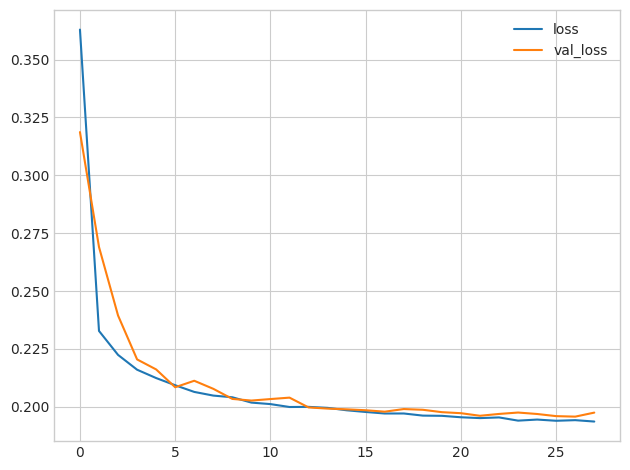

In [28]:
#Plotting loss and validation loss
hd_df.loc[:, ['loss', 'val_loss']].plot()